In [1]:
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats as scipystats

import jax
import jax.numpy as jnp
from jax.scipy import stats
from jax.config import config
config.update('jax_platform_name', 'cpu')

In [2]:
plt.style.use("default")

In [3]:
downstream_posteriors_dirname = "../../../results/adult-reduced/downstream-posteriors/"
real_data_results_dirname = "../../../results/adult-reduced/real-data-results/"
dpvi_posteriors_dirname = "../../../results/adult-reduced/dpvi-posteriors/"
figdir = "../../../figures/adult-reduced/"


epsilon = 1.0
repeat = 4
syn_data_name = "Syn. data $\\bar{p}_n(Q)$"

filename = downstream_posteriors_dirname + "{}_{}.p".format(repeat, epsilon)
with open(filename, "rb") as file:
    posterior_obj = pickle.load(file)

filename = dpvi_posteriors_dirname + "{}_{}.p".format(repeat, epsilon)
with open(filename, "rb") as file:
    dpvi_obj = pickle.load(file)

filename = real_data_results_dirname + "results.p".format(repeat)
with open(filename, "rb") as file:
    real_data_obj = pickle.load(file)

marginalised_laplace_approxes = posterior_obj["marginalised_laplace_approxes"]
marginalised_laplace_approxes = (
    jnp.stack([la[0] for la in marginalised_laplace_approxes], axis=0),
    jnp.stack([la[1] for la in marginalised_laplace_approxes], axis=0)
)
dpvi_posterior = dpvi_obj["dpvi_posterior"]

nondp_laplace_approx = real_data_obj["nondp_laplace_approx"]

In [4]:
@jax.jit
def laplace_approx_mix_pdf(xs, laplace_approxes, i):
    means, covs = laplace_approxes

    if len(means.shape) == 1:
        return stats.norm.pdf(xs, loc=means[i], scale=jnp.sqrt(covs[i, i]))

    variances = covs.diagonal(axis1=1, axis2=2)
    ys = jax.vmap(
        lambda mean, var: stats.norm.pdf(xs, loc=mean, scale=var**0.5),
        (0, 0), 0
    )(means[:, i], variances[:, i])
    return ys.mean(axis=0)

def sample_laplace_approx(rng, size, laplace_approxes):
    means, covs = laplace_approxes
    d = means[0].shape[0]
    rng, ind_key = jax.random.split(rng)
    rng, sample_key = jax.random.split(rng, 2)
    inds = jax.random.choice(ind_key, len(means), (size,), replace=True)
    sample_means = means[inds]
    sample_covs = covs[inds]
    samples = jax.random.multivariate_normal(sample_key, sample_means, sample_covs)
    return samples

In [5]:
def variance_correction(post_means, post_variances, n_syn, n_real):
    total_mean = post_means.mean()
    combined_var = post_means.var() + post_variances.mean()
    c = n_syn / n_real
    corrected_var = (1 + 1 / c)**(-1) * (combined_var - post_variances.mean())
    return scipystats.norm(loc=total_mean, scale=np.sqrt(corrected_var))

n_real = real_data_obj["n_orig"]
n_syn_dataset = 10 * n_real
syn_means = marginalised_laplace_approxes[0]
syn_covs = marginalised_laplace_approxes[1]
combined_approximations = [
    variance_correction(syn_means[:, i], syn_covs[:, i, i], n_syn_dataset, n_real)
    for i in range(syn_means.shape[1])
]

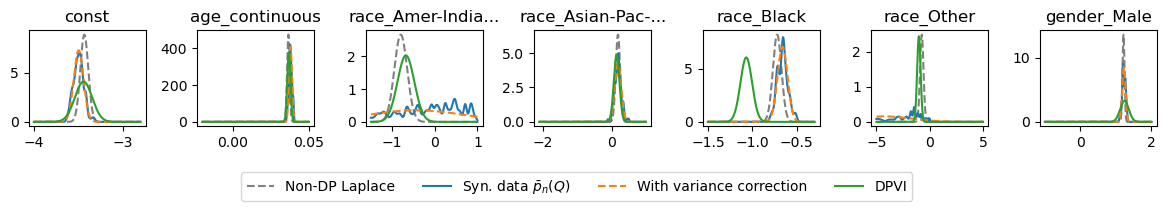

In [6]:
nondp_laplace_mean, nondp_laplace_cov = nondp_laplace_approx
dim = nondp_laplace_mean.shape[0]
fig, axes = plt.subplots(1, dim, figsize=(1.7 * dim, 1.7))
coef_names = ["const"] + real_data_obj["reordered_columns"]
max_name_len = 15
coef_names = [name[:max_name_len] + "..." if len(name) > max_name_len else name for name in coef_names]
xlims = [
    (-4, -2.8),
    (-0.02, 0.05),
    (-1.5, 1.0),
    (-2.1, 1.0),
    (-1.5, -0.3),
    (-5, 5),
    (-1, 2)
]
for i in range(dim):
    ax = axes[i]
    ax.set_title(coef_names[i])

    xs = jnp.linspace(xlims[i][0], xlims[i][1], 1000)

    mean = nondp_laplace_mean[i]
    std = np.sqrt(nondp_laplace_cov[i, i])
    # xs = jnp.linspace(-1, 1, 300) * 10 * std + mean
    ax.plot(xs, stats.norm.pdf(xs, loc=mean, scale=std), color="grey", linestyle="dashed", label="Non-DP Laplace")
    ax.plot(xs, laplace_approx_mix_pdf(xs, marginalised_laplace_approxes, i), label=syn_data_name)
    ax.plot(xs, combined_approximations[i].pdf(xs), linestyle="dashed", label="With variance correction")

    mean = dpvi_posterior[0][i]
    std = dpvi_posterior[1][i, i]**0.5
    # xs = jnp.linspace(-1, 1, 300) * 10 * std + mean
    ax.plot(xs, laplace_approx_mix_pdf(xs, dpvi_posterior, i), label="DPVI")

    # ax.legend()

leg_h, leg_l = axes[0].get_legend_handles_labels()
# plt.tight_layout()
fig.legend(leg_h, leg_l, loc="upper center", bbox_to_anchor=(0.5, -0.00), ncol=4)
plt.tight_layout()
plt.savefig(figdir + "posteriors.pdf", bbox_inches="tight")
plt.show()

In [7]:
@jax.jit
def monte_carlo_posterior_intervals(rng, laplace_approximations, conf_levels, mc_samples=1000):
    samples = sample_laplace_approx(rng, mc_samples, laplace_approximations)
    lbs = (1 - conf_levels) / 2
    ubs = 1 - lbs
    quantiles = conf_levels
    bounds = jnp.stack((lbs, ubs, quantiles), axis=1)
    quantiles = jax.vmap(
        lambda bounds: jnp.quantile(samples, bounds, axis=0), 
        0, 0
    )(bounds) # (conf_level, lower/upper, dimension)
    return quantiles

@jax.jit
def has_coverage_width(rng, laplace_approximations, conf_levels, true_params, mc_samples=1000):
    intervals = monte_carlo_posterior_intervals(rng, laplace_approximations, conf_levels)
    has_coverage = ((intervals[:, 0, :] <= true_params) & (intervals[:, 1, :] >= true_params)).astype(int)
    width = intervals[:, 1, :] - intervals[:, 0, :]
    return has_coverage, width, intervals[:, 2, :]

@jax.jit
def has_coverage_width_gaussian(posterior, conf_levels, true_params):
    mean, cov = posterior
    lbs = (1 - conf_levels) / 2
    ubs = 1 - lbs
    quantiles = conf_levels
    bounds = jnp.stack((lbs, ubs, quantiles), axis=1)
    intervals = jax.vmap(
        lambda bounds, mean, std: stats.norm.ppf(bounds, loc=mean, scale=std),
        (None, 0, 0), 2
    )(bounds, mean, cov.diagonal()**0.5)

    has_coverage = ((intervals[:, 0, :] <= true_params) & (intervals[:, 1, :] >= true_params)).astype(int)
    width = intervals[:, 1, :] - intervals[:, 0, :]
    return has_coverage, width, intervals[:, 2, :]

In [8]:

true_params = np.array(nondp_laplace_mean)
conf_levels = jnp.linspace(0.05, 0.95, 19)

rng = jax.random.PRNGKey(4628368)
all_records = []
def conf_int_record(obj, conf_level, type, width, coverage, quantile, dim):
    return {
        "epsilon": obj["epsilon"],
        "delta": obj["delta"],
        "repeat": obj["repeat"],
        "width": float(width),
        "has_coverage": int(coverage),
        "quantile": float(quantile),
        "dim": dim,
        "conf_level": float(conf_level),
        "type": type,
    }

posteriors_by_eps = {}
for path in Path(downstream_posteriors_dirname).glob("*.p"):
    with open(path, "rb") as file:
        obj = pickle.load(file)
    marginalised_posteriors = obj["marginalised_laplace_approxes"]
    marginalised_posteriors = (
        jnp.stack([la[0] for la in marginalised_posteriors], axis=0),
        jnp.stack([la[1] for la in marginalised_posteriors], axis=0)
    )
    eps = obj["epsilon"]
    if eps not in posteriors_by_eps.keys():
        posteriors_by_eps[eps] = []
    posteriors_by_eps[eps].append(marginalised_posteriors)

    rng, key = jax.random.split(rng)
    marginalised_coverage, marginalised_width, marginalised_quantiles = has_coverage_width(
        key, marginalised_posteriors, conf_levels, true_params
    )

    for j, (coverage, width, quantiles) in enumerate(zip(marginalised_coverage, marginalised_width, marginalised_quantiles)):
        for i in range(true_params.shape[0]):
            all_records.append(conf_int_record(obj, conf_levels[j], syn_data_name, width[i], coverage[i], quantiles[i], i))

    syn_means = marginalised_posteriors[0]
    syn_covs = marginalised_posteriors[1]
    variance_correction_posteriors = [
        variance_correction(syn_means[:, i], syn_covs[:, i, i], n_syn_dataset, n_real)
        for i in range(syn_means.shape[1])
    ]
    variance_correction_mean = jnp.array([
        vcp.mean() for vcp in variance_correction_posteriors
    ]).reshape((1, -1))
    variance_correction_var = jnp.array([vcp.var() for vcp in variance_correction_posteriors])
    variance_correction_cov = jnp.diag(variance_correction_var)
    variance_correction_cov = variance_correction_cov.reshape((1, *variance_correction_cov.shape))

    rng, key = jax.random.split(rng)
    variance_correction_coverage, variance_correction_width, variance_correction_quantiles = has_coverage_width(
        key, (variance_correction_mean, variance_correction_cov), conf_levels, true_params
    )
    for j, (coverage, width, quantiles) in enumerate(zip(variance_correction_coverage, variance_correction_width, variance_correction_quantiles)):
        for i in range(true_params.shape[0]):
            all_records.append(conf_int_record(obj, conf_levels[j], "With variance correction", width[i], coverage[i], quantiles[i], i))

dpvi_posteriors_by_eps = {}
for path in Path(dpvi_posteriors_dirname).glob("*.p"):
    with open(path, "rb") as file:
        obj = pickle.load(file)

    posterior = obj["dpvi_posterior"]
    eps = obj["epsilon"]
    if eps not in dpvi_posteriors_by_eps.keys():
        dpvi_posteriors_by_eps[eps] = []
    dpvi_posteriors_by_eps[eps].append(posterior)

    dpvi_coverage, dpvi_width, dpvi_quantiles = has_coverage_width_gaussian(posterior, conf_levels, true_params)
    for j, (coverage, width, quantiles) in enumerate(zip(dpvi_coverage, dpvi_width, dpvi_quantiles)):
        for i in range(true_params.shape[0]):
            all_records.append(conf_int_record(obj, conf_levels[j], "DPVI", width[i], coverage[i], quantiles[i], i))


df = pd.DataFrame.from_records(all_records)
df["coefficient"] = true_params[df.dim]
df["coefficient_name"] = np.array(coef_names)[df.dim]

In [9]:
df

,epsilon,delta,repeat,width,has_coverage,quantile,dim,conf_level,type,coefficient,coefficient_name
0,1.00,4.717075e-10,16,0.005551,0,-3.615994,0,0.05,Syn. data $\bar{p}_n(Q)$,-3.432228,const
1,1.00,4.717075e-10,16,0.000156,0,0.036201,1,0.05,Syn. data $\bar{p}_n(Q)$,0.036510,age_continuous
2,1.00,4.717075e-10,16,0.087490,0,-3.535966,2,0.05,Syn. data $\bar{p}_n(Q)$,-0.799317,race_Amer-India...
3,1.00,4.717075e-10,16,0.010766,0,-0.157604,3,0.05,Syn. data $\bar{p}_n(Q)$,0.186028,race_Asian-Pac-...
4,1.00,4.717075e-10,16,0.007734,0,-0.798712,4,0.05,Syn. data $\bar{p}_n(Q)$,-0.719484,race_Black
...,...,...,...,...,...,...,...,...,...,...,...
23935,0.25,4.717075e-10,0,0.565734,0,-0.205198,2,0.95,DPVI,-0.799317,race_Amer-India...
23936,0.25,4.717075e-10,0,0.618400,1,0.189403,3,0.95,DPVI,0.186028,race_Asian-Pac-...
23937,0.25,4.717075e-10,0,0.706049,1,-0.548878,4,0.95,DPVI,-0.719484,race_Black
23938,0.25,4.717075e-10,0,1.785834,1,-0.473478,5,0.95,DPVI,-0.741805,race_Other


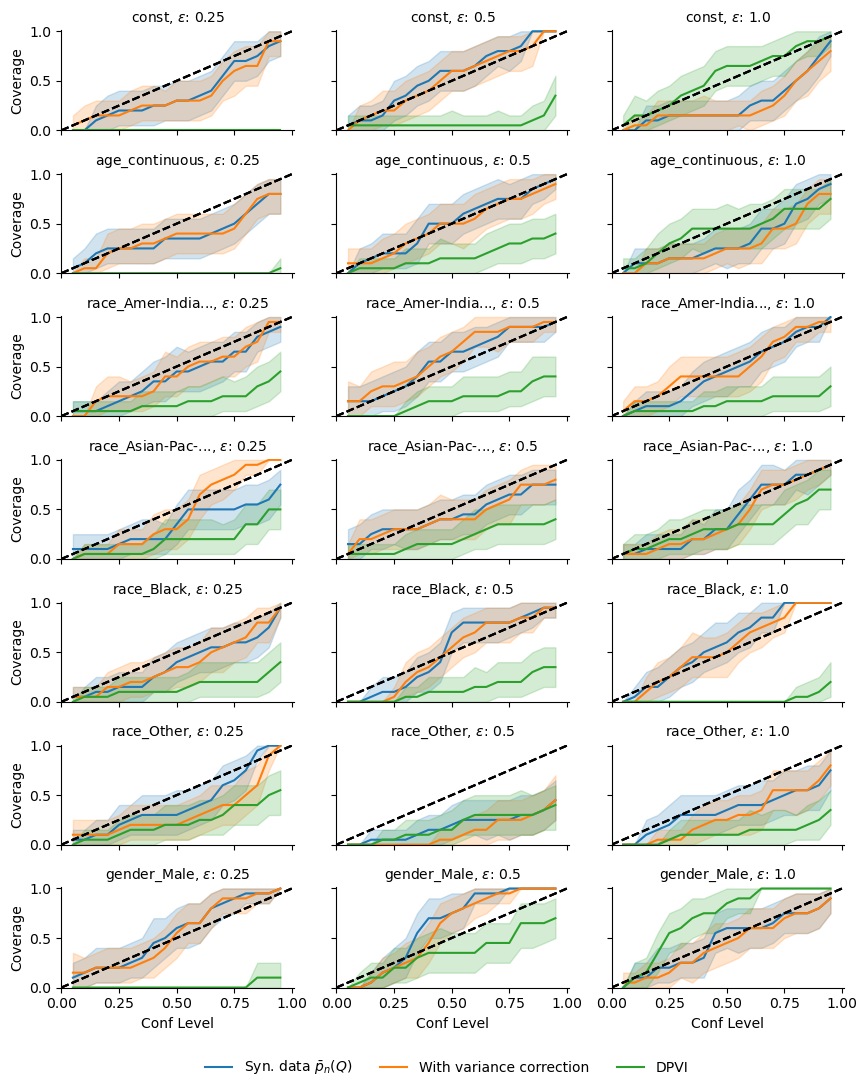

In [10]:
cdf = df.copy()
g = sns.FacetGrid(cdf, col="epsilon", row="coefficient_name", hue="type", row_order=coef_names[:-1], xlim=(0, 1.01), ylim=(0, 1.01), height=1.5, aspect=2.0)
g.map_dataframe(sns.lineplot, x="conf_level", y="has_coverage")
diag = (0.0, 1.01)
g.map(lambda **kws: plt.gca().plot(diag, diag, linestyle="dashed", color="black"))
g.add_legend(title="", loc="upper center", bbox_to_anchor=(0.35, -0.00), ncol=3)
g.set_titles(template="{row_name}, $\epsilon$: {col_name}")
g.set_xlabels("Conf Level")
g.set_ylabels("Coverage")
plt.savefig(figdir + "coverages.pdf", bbox_inches="tight")
plt.show()

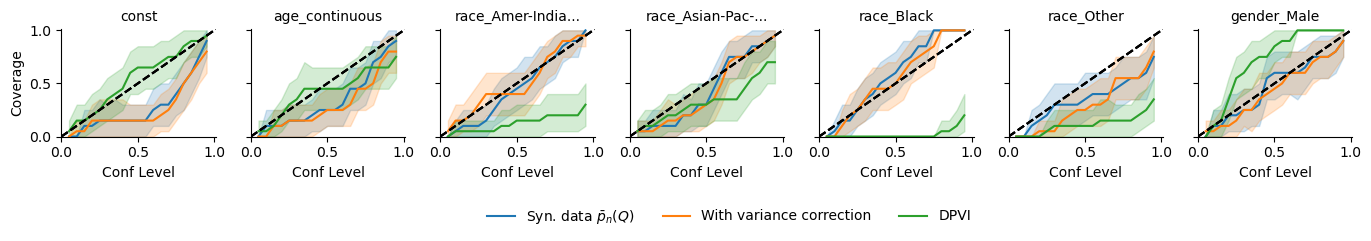

In [11]:
cdf = df.copy()
cdf = cdf[cdf.epsilon == 1.0]
g = sns.FacetGrid(cdf, row="epsilon", col="coefficient_name", hue="type", col_order=coef_names[:-1], xlim=(0, 1.01), ylim=(0, 1.01), height=2.00, aspect=1.0)
g.map_dataframe(sns.lineplot, x="conf_level", y="has_coverage")
diag = (0.0, 1.01)
g.map(lambda **kws: plt.gca().plot(diag, diag, linestyle="dashed", color="black"))
g.add_legend(title="", loc="upper center", bbox_to_anchor=(0.4, -0.00), ncol=3)
g.set_titles(template="{col_name}")
g.set_xlabels("Conf Level")
g.set_ylabels("Coverage")
plt.savefig(figdir + "coverages_eps_1.pdf", bbox_inches="tight")
plt.show()

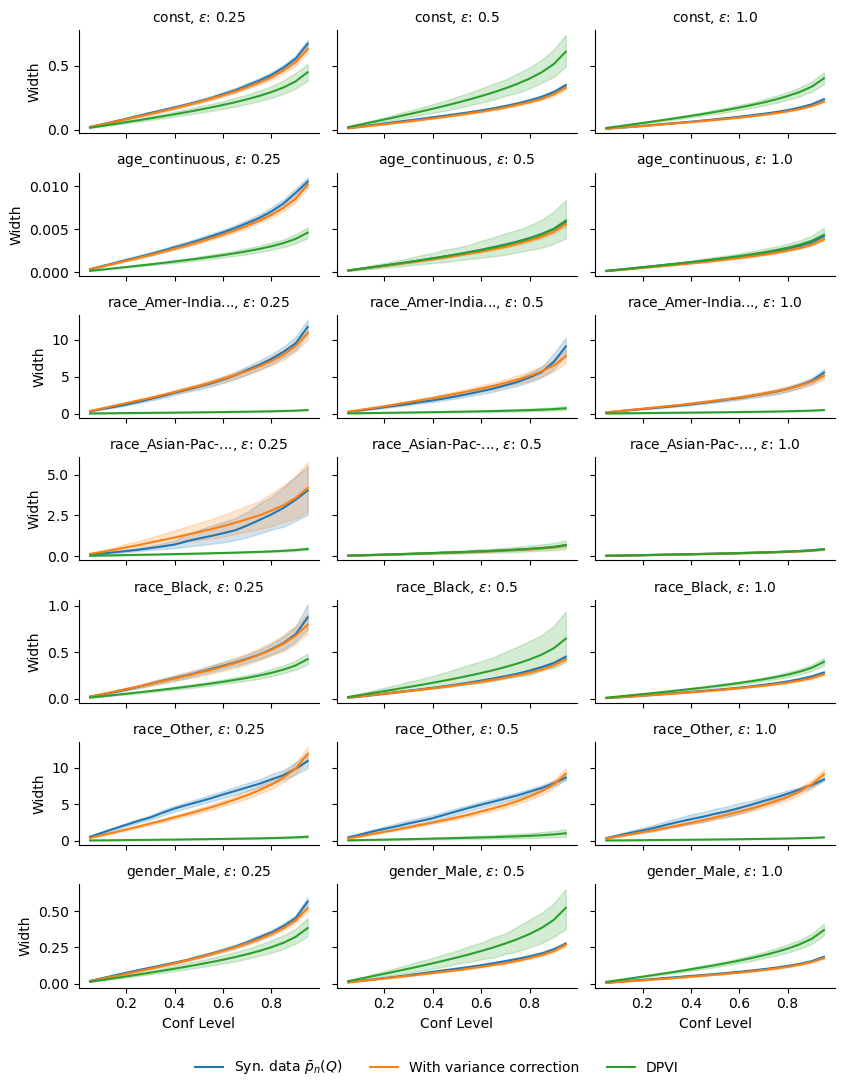

In [12]:
cdf = df.copy()
g = sns.FacetGrid(cdf, col="epsilon", row="coefficient_name", hue="type", row_order=coef_names[:-1], sharey="row", height=1.5, aspect=2.0)
g.map_dataframe(sns.lineplot, x="conf_level", y="width")
g.add_legend(title="", loc="upper center", bbox_to_anchor=(0.35, -0.00), ncol=3)
g.set_titles(template="{row_name}, $\epsilon$: {col_name}")
g.set_xlabels("Conf Level")
g.set_ylabels("Width")
plt.savefig(figdir + "widths.pdf", bbox_inches="tight")
plt.show()

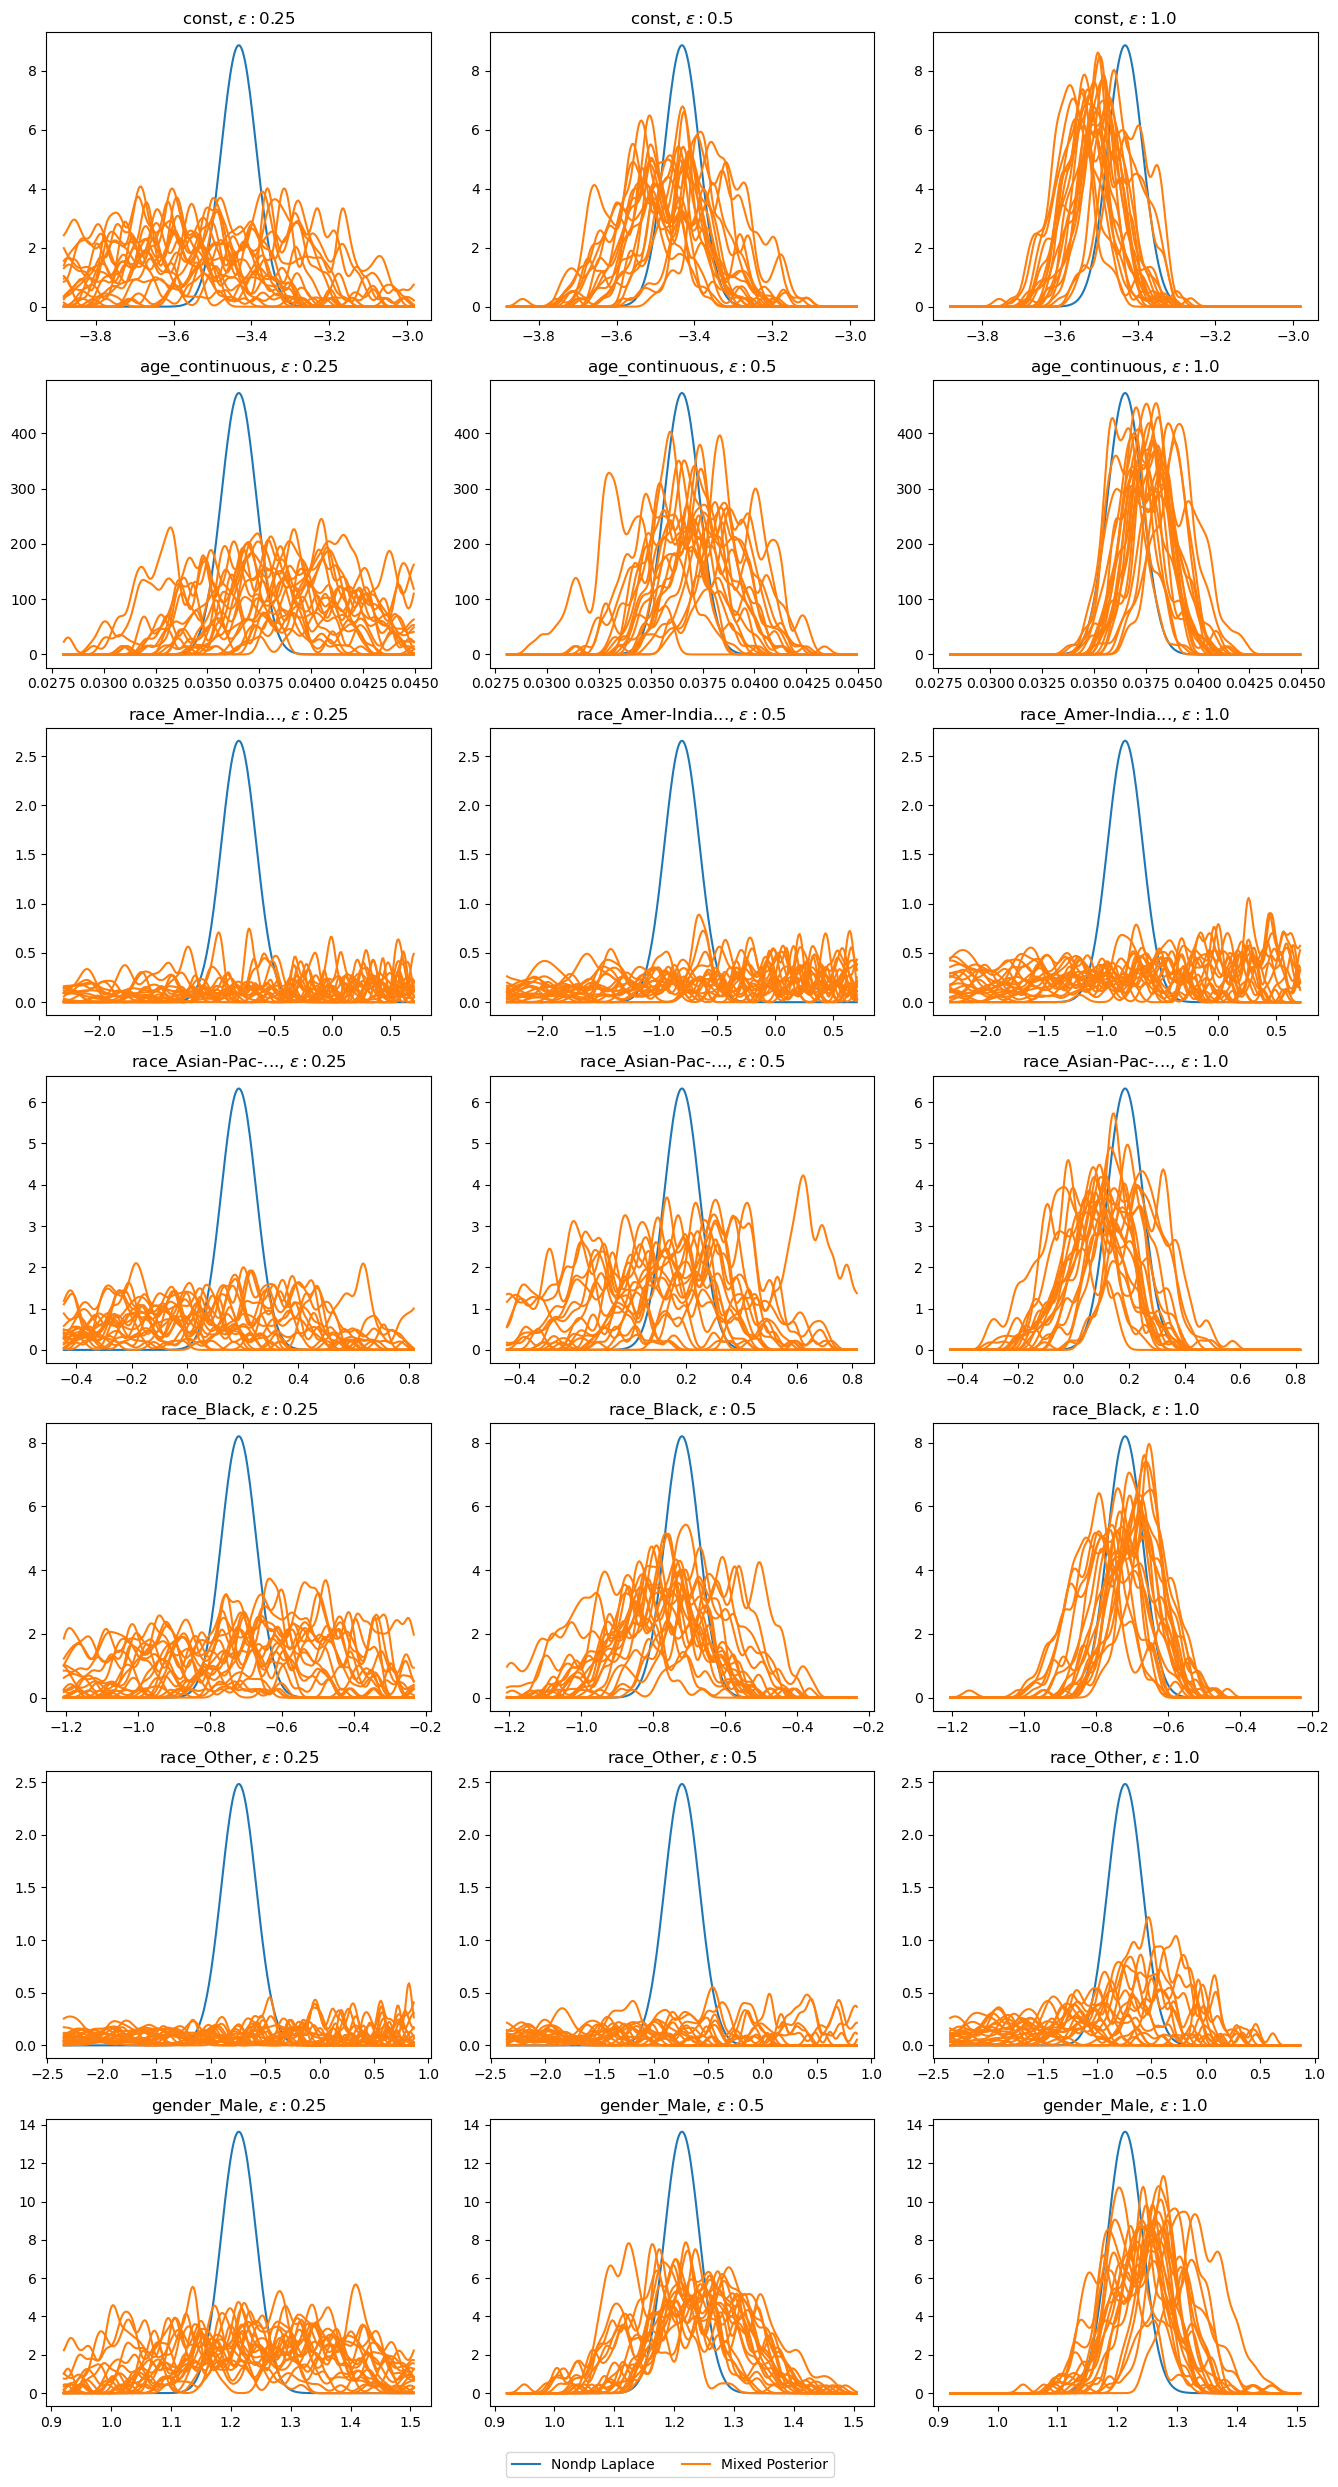

In [13]:
n_eps = len(posteriors_by_eps.keys())
epsilons = list(posteriors_by_eps.keys())
epsilons.sort()
fig, axes = plt.subplots(dim, n_eps, figsize=(n_eps * 4.5, 3.5 * dim))
for i in range(dim):
    for j, eps in enumerate(epsilons):
        ax = axes[i, j]
        ax.set_title("{}, $\epsilon: {}$".format(coef_names[i], eps))

        mean = nondp_laplace_mean[i]
        std = np.sqrt(nondp_laplace_cov[i, i])
        xs = jnp.linspace(-1, 1, 300) * 10 * std + mean
        ax.plot(xs, stats.norm.pdf(xs, loc=mean, scale=std), label="Nondp Laplace")

        for k, marginalised_laplace_approxes in enumerate(posteriors_by_eps[eps]):
            ax.plot(xs, laplace_approx_mix_pdf(xs, marginalised_laplace_approxes, i), label="Mixed Posterior", color="C1")
            if i == 0 and j == 0 and k == 0:
                leg_h, leg_l = ax.get_legend_handles_labels()

plt.tight_layout()
fig.legend(leg_h, leg_l, loc="upper center", bbox_to_anchor=(0.5, -0.00), ncol=2)
plt.savefig(figdir + "all_posteriors.pdf", bbox_inches="tight")
plt.show()

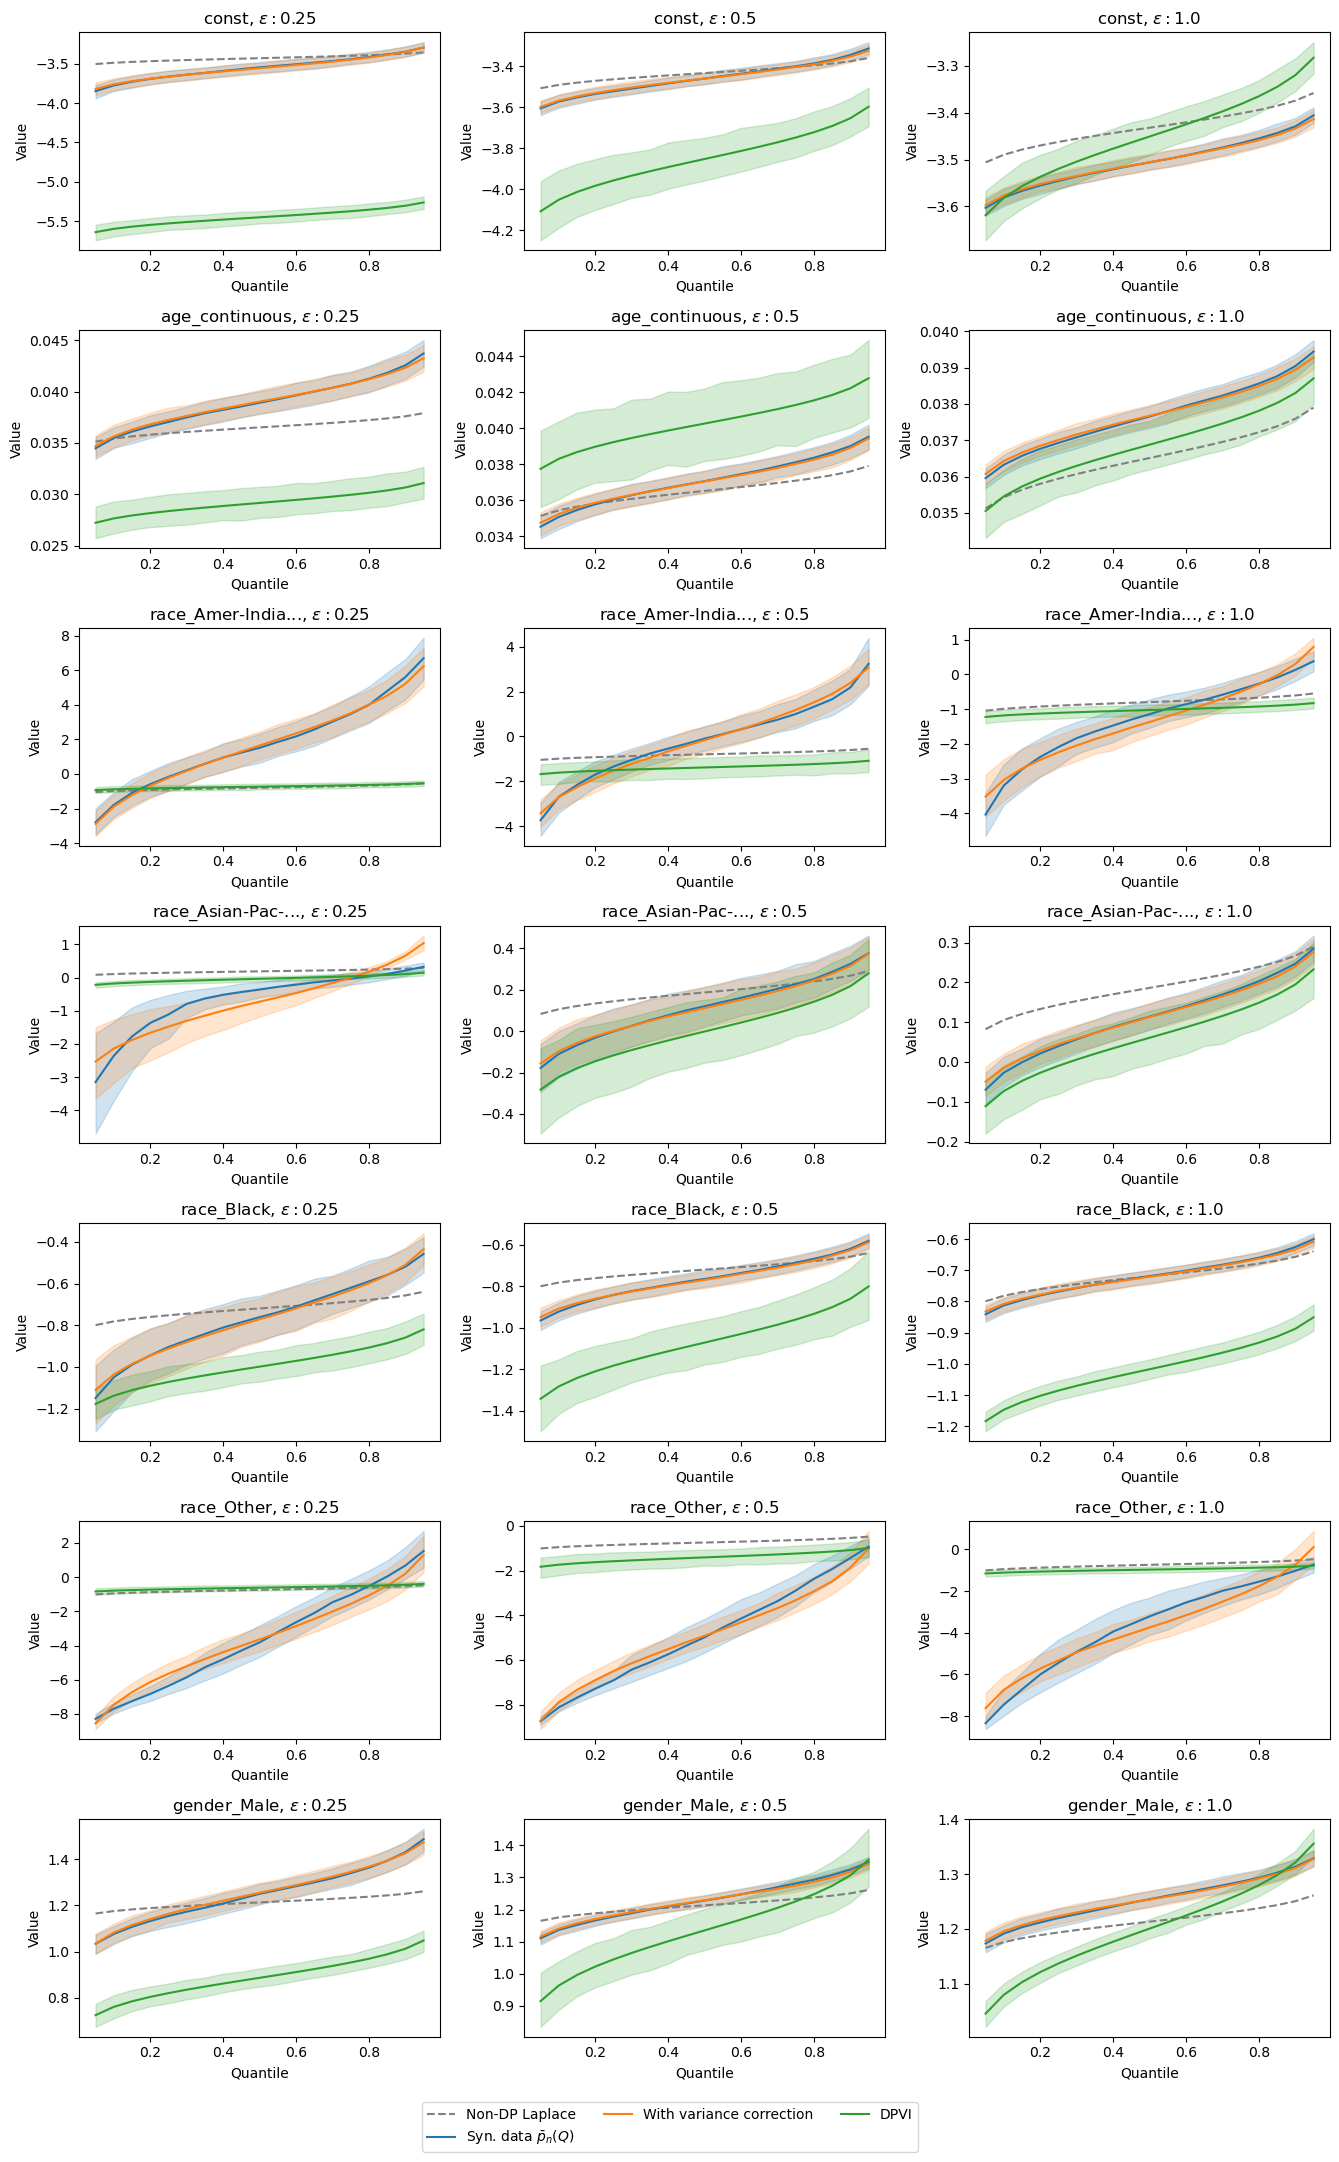

In [14]:
quantiles = conf_levels
fig, axes = plt.subplots(dim, n_eps, figsize=(n_eps * 4.5, 3.0 * dim))
for i in range(dim):
    for j, eps in enumerate(epsilons):
        ax = axes[i, j]
        ax.set_title("{}, $\epsilon: {}$".format(coef_names[i], eps))
        ax.set_ylabel("Value")
        ax.set_xlabel("Quantile")

        nondp_quantiles = stats.norm.ppf(quantiles, loc=nondp_laplace_mean[i], scale=nondp_laplace_cov[i, i]**0.5)
        ax.plot(quantiles, nondp_quantiles, color="grey", linestyle="dashed", label="Non-DP Laplace")

        cdf = df[df.dim == i]
        cdf = cdf[cdf.epsilon == eps]
        sns.lineplot(data=cdf, x="conf_level", y="quantile", hue="type", ax=ax)
        ax.get_legend().remove()
        
        
leg_h, leg_l = axes[0, 0].get_legend_handles_labels()
plt.tight_layout()
fig.legend(leg_h, leg_l, loc="upper center", bbox_to_anchor=(0.5, -0.00), ncol=3)
plt.savefig(figdir + "posterior_quantiles.pdf")
plt.show()

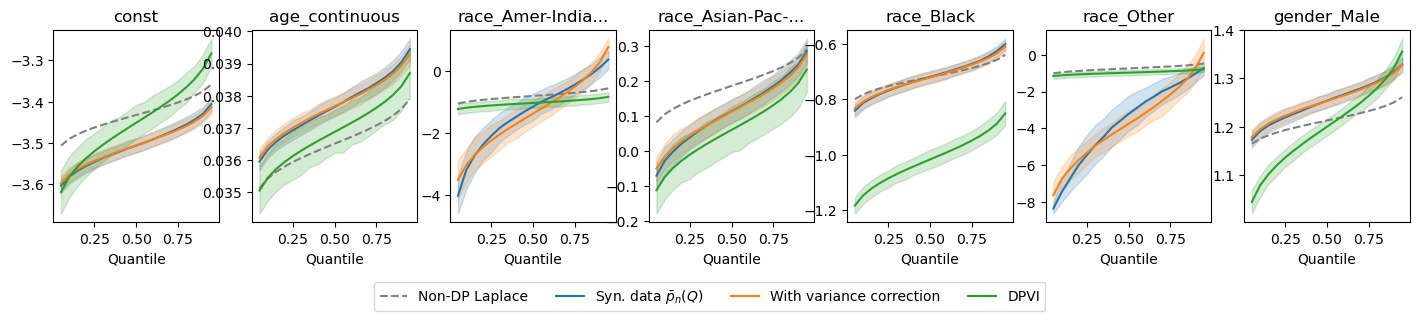

In [15]:
quantiles = conf_levels
fig, axes = plt.subplots(1, dim, figsize=(2.5 * dim, 2.5))
for i in range(dim):
    eps = 1.0
    ax = axes[i]
    ax.set_title(coef_names[i])
    ax.set_xlabel("Quantile")

    nondp_quantiles = stats.norm.ppf(quantiles, loc=nondp_laplace_mean[i], scale=nondp_laplace_cov[i, i]**0.5)
    ax.plot(quantiles, nondp_quantiles, color="grey", linestyle="dashed", label="Non-DP Laplace")

    cdf = df[df.dim == i]
    cdf = cdf[cdf.epsilon == eps]
    sns.lineplot(data=cdf, x="conf_level", y="quantile", hue="type", ax=ax)
    ax.get_legend().remove()
        
    ax.set_ylabel("")
        
leg_h, leg_l = axes[0].get_legend_handles_labels()
# plt.tight_layout()
fig.legend(leg_h, leg_l, loc="upper center", bbox_to_anchor=(0.5, -0.10), ncol=4)
plt.savefig(figdir + "posterior_quantiles_eps_1.pdf", bbox_inches="tight")
plt.show()